<a href="https://colab.research.google.com/github/GopalKrishna-India/ML_AI_for_TOF_Mapping/blob/main/Jhansi_BuildingTensorFlowModel.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 1- Install the earth engine API, Google Cloud API and authenticate

In [1]:
!pip install earthengine-api
from google.colab import auth

auth.authenticate_user()

# Import the Earth Engine API and initialize it.
import ee

ee.Authenticate()
ee.Initialize(project='ee-geoinformers')

# 2-Import the tensorflow library and import the training and testing data

In [6]:
import tensorflow as tf

#tf.enable_eager_execution()
print(tf.__version__)

trainFilePath = 'gs://treemapping_tofi/TreeMappingTest/Planet_training_points_Jhansi.tfrecord.gz'
testFilePath = 'gs://treemapping_tofi/TreeMappingTest/Planet_testing_points_Jhansi.tfrecord.gz'

print('Found training file.' if tf.io.gfile.exists(trainFilePath)
    else 'No training file found.')

# Create a dataset from the TFRecord file in Cloud Storage.
trainDataset = tf.data.TFRecordDataset(trainFilePath, compression_type='GZIP')
# Print the first record to check.
print(iter(trainDataset).next())


2.15.0
Found training file.
tf.Tensor(b"\n\xec\x01\n\x0f\n\x03red\x12\x08\x12\x06\n\x04\x9c\xa2\xa3=\n\x12\n\x06random\x12\x08\x12\x06\n\x04\rn-?\n\x1c\n\x10NDVI_temporalAvg\x12\x08\x12\x06\n\x04Q\xf1\x1a?\n\x16\n\ncover_code\x12\x08\x12\x06\n\x04\x00\x00\xc0@\n\x11\n\x05green\x12\x08\x12\x06\n\x04\xecQ\xb8=\n\x10\n\x04blue\x12\x08\x12\x06\n\x042\xe6.=\n\x0f\n\x03nir\x12\x08\x12\x06\n\x04\xd7\xa3\xb0>\n\x10\n\x04ndvi\x12\x08\x12\x06\n\x04\xaa\xb8\x1f?\n\x11\n\x05class\x12\x08\x12\x06\n\x04\x00\x00\x80?\n!\n\x0csystem:index\x12\x11\n\x0f\n\r1_1_1_1_1_0_1\n\x11\n\x05ratio\x12\x08\x12\x06\n\x04\x08'm>", shape=(), dtype=string)


# 3-Set the label and feature names

In [9]:
label = "class"

featureNames = list(['blue','green','red','nir',"ratio","ndvi","NDVI_temporalAvg", "cover_code"]) #canopy Height has cover_code prpoperty.
featureNames.append(label)

l = len(featureNames)
print(l)
featureNames = sorted(featureNames)
featureNames.append(label)

# List of fixed-length features, all of which are float32.
columns = [
  tf.io.FixedLenFeature(shape=[1], dtype=tf.float32) for k in featureNames
]

# Dictionary with names as keys, features as values.
featuresDict = dict(zip(featureNames, columns))

print(featuresDict)

9
{'NDVI_temporalAvg': FixedLenFeature(shape=[1], dtype=tf.float32, default_value=None), 'blue': FixedLenFeature(shape=[1], dtype=tf.float32, default_value=None), 'class': FixedLenFeature(shape=[1], dtype=tf.float32, default_value=None), 'cover_code': FixedLenFeature(shape=[1], dtype=tf.float32, default_value=None), 'green': FixedLenFeature(shape=[1], dtype=tf.float32, default_value=None), 'ndvi': FixedLenFeature(shape=[1], dtype=tf.float32, default_value=None), 'nir': FixedLenFeature(shape=[1], dtype=tf.float32, default_value=None), 'ratio': FixedLenFeature(shape=[1], dtype=tf.float32, default_value=None), 'red': FixedLenFeature(shape=[1], dtype=tf.float32, default_value=None)}


# Read a serialized example into the structure defined by featuresDict.

In [10]:
def parse_tfrecord(example_proto):
  """The parsing function.

  Read a serialized example into the structure defined by featuresDict.

  Args:
    example_proto: a serialized Example.

  Returns:
    A tuple of the predictors dictionary and the label, cast to an `int32`.
  """
  parsed_features = tf.io.parse_single_example(example_proto, featuresDict)
  labels = parsed_features.pop(label)
  return parsed_features, tf.cast(labels, tf.int32)

# Map the function over the dataset.
parsedDataset = trainDataset.map(parse_tfrecord, num_parallel_calls=5)

# Print the first parsed record to check.
print(iter(parsedDataset).next())

({'NDVI_temporalAvg': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([0.6052447], dtype=float32)>, 'blue': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([0.0427], dtype=float32)>, 'cover_code': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([6.], dtype=float32)>, 'green': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([0.09], dtype=float32)>, 'ndvi': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([0.6239115], dtype=float32)>, 'nir': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([0.345], dtype=float32)>, 'ratio': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([0.2315942], dtype=float32)>, 'red': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([0.0799], dtype=float32)>}, <tf.Tensor: shape=(1,), dtype=int32, numpy=array([1], dtype=int32)>)


# Build the model

Epoch 1/20
10/10 [==============================] - 7s 64ms/step - loss: 1.0946 - accuracy: 0.5623
Epoch 2/20
10/10 [==============================] - 1s 68ms/step - loss: 0.4717 - accuracy: 0.9033
Epoch 3/20
10/10 [==============================] - 1s 69ms/step - loss: 0.1977 - accuracy: 0.9637
Epoch 4/20
10/10 [==============================] - 1s 69ms/step - loss: 0.1025 - accuracy: 0.9823
Epoch 5/20
10/10 [==============================] - 1s 69ms/step - loss: 0.0260 - accuracy: 0.9957
Epoch 6/20
10/10 [==============================] - 1s 68ms/step - loss: 0.5883 - accuracy: 0.7483
Epoch 7/20
10/10 [==============================] - 1s 69ms/step - loss: 1.1530 - accuracy: 0.6423
Epoch 8/20
10/10 [==============================] - 1s 87ms/step - loss: 0.2666 - accuracy: 0.9527
Epoch 9/20
10/10 [==============================] - 1s 98ms/step - loss: 0.0458 - accuracy: 0.9767
Epoch 10/20
10/10 [==============================] - 1s 82ms/step - loss: 0.0156 - accuracy: 0.9920
Epoch 11/

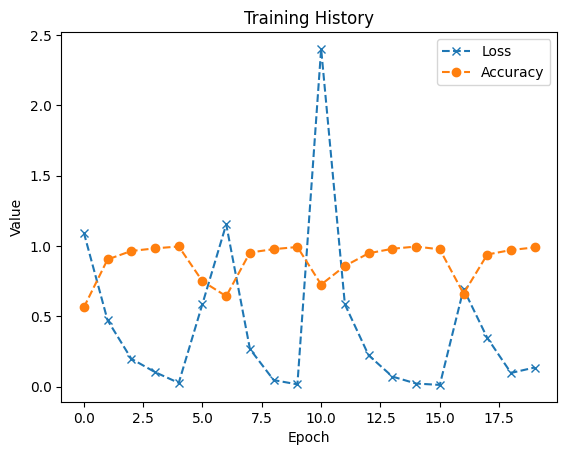

In [23]:
# Commented out IPython magic to ensure Python compatibility.
from tensorflow import keras
import matplotlib.pyplot as plt

# How many classes there are in the model.
nClasses = 6

# Add features .
inputDataset = parsedDataset #.map(addFeatures)

# Keras requires inputs as a tuple. Note that the inputs must be in the
# right shape. Also note that to use the categorical_crossentropy loss,
# the label needs to be turned into a one-hot vector.

def toTuple(data_dict, label):
  #return tf.transpose(list(dict.values())), tf.one_hot(indices=label, depth=nClasses)
    return (tf.expand_dims(tf.transpose(list(data_dict.values())), 1),
            tf.expand_dims(tf.one_hot(indices=label, depth=nClasses), 1))


# Repeat the input dataset as many times as necessary in batches.
inputDataset = inputDataset.map(toTuple).shuffle(3000).batch(300).repeat()

# Define the layers in the model.
model = tf.keras.models.Sequential([
tf.keras.layers.Input((None, None, l-1,)),
tf.keras.layers.Conv2D(512, (1, 1), activation=tf.nn.relu),
tf.keras.layers.Dropout(0.25),
tf.keras.layers.Conv2D(256, (1, 1), activation=tf.nn.relu),
tf.keras.layers.Dropout(0.25),
tf.keras.layers.Conv2D(nClasses, (1, 1), activation=tf.nn.softmax)
])

# Compile the model with the specified loss function.
# Compile the model with the specified loss function.
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.003),
              loss='categorical_crossentropy',
              metrics=['accuracy'])


# Fit the model to the training data.
# Don't forget to specify `steps_per_epoch` when calling `fit` on a dataset.
training = model.fit(x=inputDataset, epochs=20,steps_per_epoch=10)

# Plot the training history
plt.plot(training.history['loss'], 'x--', label='Loss')
plt.plot(training.history['accuracy'], 'o--', label='Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Value')
plt.title('Training History')
plt.legend()
plt.show()

# **Identify the best learning rate**

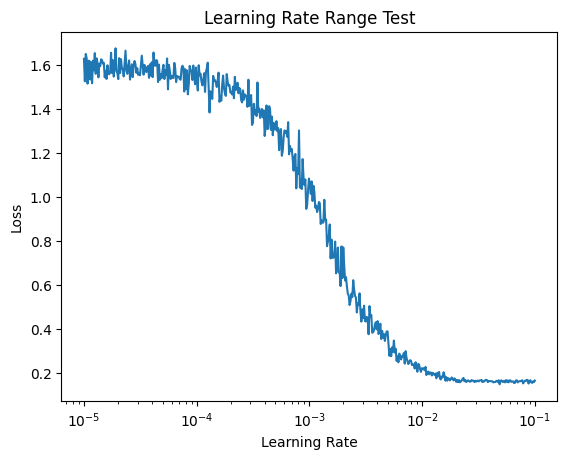

In [ ]:
from tensorflow import keras
import matplotlib.pyplot as plt
import numpy as np

# Define a function to build and compile the model
def build_model(learning_rate):
    model = keras.models.Sequential([
        keras.layers.Input((None, None, l-1,)),
        keras.layers.Conv2D(512, (1, 1), activation=tf.nn.relu),
        keras.layers.Dropout(0.15),
        keras.layers.Conv2D(256, (1, 1), activation=tf.nn.relu),
        keras.layers.Dropout(0.15),
        keras.layers.Conv2D(nClasses, (1, 1), activation=tf.nn.softmax)
    ])

    optimizer = keras.optimizers.Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
    return model

# Define a function to perform the learning rate range test
def learning_rate_range_test(input_dataset, initial_lr, final_lr, epochs, steps_per_epoch):
    # Define the range of learning rates to test
    learning_rates = np.logspace(np.log10(initial_lr), np.log10(final_lr), num=epochs*steps_per_epoch)

    # Initialize lists to store learning rates and corresponding losses
    lr_values = []
    losses = []

    # Iterate over the learning rates
    for lr in learning_rates:
        # Build and compile the model with the current learning rate
        model = build_model(lr)

        # Fit the model to a subset of the dataset for one epoch
        history = model.fit(x=input_dataset, epochs=1, steps_per_epoch=steps_per_epoch, verbose=0)

        # Record the learning rate and the loss
        lr_values.append(lr)
        losses.append(history.history['loss'][0])

    # Plot the learning rate vs. loss
    plt.plot(lr_values, losses)
    plt.xscale('log')
    plt.xlabel('Learning Rate')
    plt.ylabel('Loss')
    plt.title('Learning Rate Range Test')
    plt.show()

# Define the parameters for the learning rate range test
initial_lr = 1e-5  # Initial learning rate
final_lr = 1e-1    # Final learning rate
epochs = 50        # Number of epochs to simulate
steps_per_epoch = 10  # Number of steps per epoch

# Perform the learning rate range test
learning_rate_range_test(inputDataset, initial_lr, final_lr, epochs, steps_per_epoch)


# Do the data validation using the test data

In [24]:
testDataset = (
  tf.data.TFRecordDataset(testFilePath, compression_type='GZIP')
    .map(parse_tfrecord, num_parallel_calls=5)
    .map(toTuple)
    .batch(1)
)

model.evaluate(testDataset)

5703/5703 [==============================] - 14s 2ms/step - loss: 0.5855 - accuracy: 0.8327


[0.5854529142379761, 0.832719624042511]

# Save your model in your cloud bucket

In [ ]:
outputBucket = "treemapping_tofi/TreeMappingTest"
MODEL_DIR = 'gs://' + outputBucket + '/model_Jhansi'

# Save the Keras model
tf.keras.models.save_model(model, MODEL_DIR)


# Make your model readable for the earthEngine

In [ ]:
from tensorflow.python.tools import saved_model_utils

meta_graph_def = saved_model_utils.get_meta_graph_def(MODEL_DIR, 'serve')
inputs = meta_graph_def.signature_def['serving_default'].inputs
outputs = meta_graph_def.signature_def['serving_default'].outputs

# Just get the first thing(s) from the serving signature def.  i.e. this
# model only has a single input and a single output.
input_name = None
for k,v in inputs.items():
  input_name = v.name
  break

output_name = None
for k,v in outputs.items():
  output_name = v.name
  break

# Make a dictionary that maps Earth Engine outputs and inputs to
# AI Platform inputs and outputs, respectively.
import json
input_dict = "'" + json.dumps({input_name: "array"}) + "'"
output_dict = "'" + json.dumps({output_name: label}) + "'"

print(input_dict)
print(output_dict)

# Put the EEified model next to the trained model directory.
EEIFIED_DIR = 'gs://' + outputBucket + '/eeified_Jhansi'
PROJECT = 'tofi-imageupload'

#print(EEIFIED_DIR)
# You need to set the project before using the model prepare command.
!earthengine set_project {PROJECT}
!earthengine model prepare --source_dir {MODEL_DIR} --dest_dir {EEIFIED_DIR} --input {input_dict} --output {output_dict}

'{"serving_default_input_8:0": "array"}'
'{"StatefulPartitionedCall:0": "class"}'
Successfully saved project id
W0415 08:33:39.335135 137804839563264 _default.py:683] No project ID could be determined. Consider running `gcloud config set project` or setting the GOOGLE_CLOUD_PROJECT environment variable
Success: model at 'gs://treemapping_tofi/TreeMappingTest/eeified_up1' is ready to be hosted in AI Platform.


In [ ]:
#Create Model in the cloud project; need to replace modelname: image_classifier_model and project: tofi-imageupload
#!gcloud ai-platform models create {image_classifier_model} --project {YOUR_PROJECT_ID}
!gcloud ai-platform models create TOF_classifier_model_UP1 --project tofi-imageupload


Learn more about regional endpoints and see a list of available regions: https://cloud.google.com/ai-platform/prediction/docs/regional-endpoints
Using endpoint [https://ml.googleapis.com/]
Created ai platform model [projects/tofi-imageupload/models/TOF_classifier_model_UP1].


# Push your model to the AI platform

In [ ]:
import time
MODEL_NAME = 'TOF_classifier_model_Jhansi'
VERSION_NAME = 'v_Jhansi01' #'v' + str(int(time.time()))
print('Creating version: ' + VERSION_NAME)

!gcloud config set ai_platform/region global #comment this code to define new region
#!gcloud ai-platform models create image_classifier_model --project tofi-imageupload
!gcloud ai-platform versions create {VERSION_NAME} \
  --project {PROJECT} \
  --model {MODEL_NAME} \
  --origin {EEIFIED_DIR} \
  --runtime-version=2.11 \
  --framework "TENSORFLOW" \
  --python-version=3.7
#version may throw error in years to come. #Check here if error comes "https://cloud.google.com/ai-platform/prediction/docs/runtime-version-list"

Creating version: v_UP01
Updated property [ai_platform/region].
Using endpoint [https://ml.googleapis.com/]
